In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_SF3 = pd.read_csv( './data/SHARADAR_SF3_ce320d02f19d0b5d04c9557e0bc16680.zip') # read SF3 table

In [3]:
df_SF3 = df_SF3[df_SF3['securitytype'] == 'SHR']

In [4]:
SF3_tickers = df_SF3.ticker.unique()

In [5]:
SF3_investors = df_SF3.investorname.unique()

In [6]:
SF3_dates = pd.to_datetime(df_SF3.calendardate.unique()) # collect dates of investor filings

In [7]:
#unique ('investor', 'ticker') pairs
invstrTckrPair = df_SF3[['investorname', 'ticker']].drop_duplicates()

In [8]:
#unique ('investor', 'ticker') pairs we do not know when initially invested (We should eliminate them when we construct investor-investor graph)
invstrTckrPair1306 = df_SF3.query('calendardate == "2013-06-30"')[['investorname', 'ticker']]

In [9]:
#"new" unique ('investor', 'ticker') pairs from 2013-09-30
invstrTckrPair['common'] = 1
invstrTckrPair1306['common'] = 1
newInvstrTckrPair = invstrTckrPair.merge(invstrTckrPair1306, on=['investorname', 'ticker'], how='left')
newInvstrTckrPair = newInvstrTckrPair[newInvstrTckrPair.common_y.isnull()][['investorname','ticker']]

In [10]:
#Eliminate investors who invest 1000+ stocks
num_invest = newInvstrTckrPair.groupby('investorname').count()
num_invest.columns = ['num_invest']
SF3_investors = np.array(num_invest[num_invest['num_invest'] < 1000].index)

In [11]:
#Construct investor-investor edge list
SF3_dates_rev = SF3_dates.values[::-1]
df_investors = pd.DataFrame(SF3_investors, columns = ['investorname'])
df_investors['investorID'] = df_investors.index
df_investors = df_investors.astype({'investorID':'int16'})

for t in range(len(SF3_dates_rev)-1):
    #(investor, ticker) pair in quater t and t+1 respectively
    invstrTckrPair1 = df_SF3.query('calendardate == "{}"'.format(str(SF3_dates_rev[t])[:10]))[['investorname', 'ticker']]
    invstrTckrPair1 = pd.merge(invstrTckrPair1, df_investors)[['investorID', 'ticker']]
    invstrTckrPair2 = df_SF3.query('calendardate == "{}"'.format(str(SF3_dates_rev[t+1])[:10]))[['investorname', 'ticker']]
    invstrTckrPair2 = pd.merge(invstrTckrPair2, df_investors)[['investorID', 'ticker']]

    #extract new (investor, ticker) pairs in quater t+1
    invstrTckrPair1['common'] = 1.0
    invstrTckrPair2['common'] = 1.0
    newInvstrTckrPair = invstrTckrPair2.merge(invstrTckrPair1, on=['investorID', 'ticker'], how='left')
    newInvstrTckrPair = newInvstrTckrPair[newInvstrTckrPair.common_y.isnull()][['investorID','ticker']]
    
    #Assign an information weight of each Investor, based on the total number of investment in the quarter
    Investor_weight = pd.DataFrame(newInvstrTckrPair["investorID"].value_counts())
    Investor_weight["investorID"] = 1 / (Investor_weight["investorID"] + 1)
    Investor_weight = Investor_weight.rename(columns = {'investorID':'weight'})
    
    #If any new (investor, ticker) pair in t+1 share same ticker, create edge
    InvstrInvstrPair = newInvstrTckrPair.merge(newInvstrTckrPair, on=['ticker'], how='left')

    Investor_weight["investorID_x"] = Investor_weight.index
    InvstrInvstrPair = InvstrInvstrPair.merge(Investor_weight, on=['investorID_x'], how='left')

    Investor_weight = Investor_weight.rename(columns = {'investorID_x':'investorID_y'})
    InvstrInvstrPair = InvstrInvstrPair.merge(Investor_weight, on=['investorID_y'], how='left')
    InvstrInvstrPair['weight'] = InvstrInvstrPair['weight_x'] * InvstrInvstrPair['weight_y'] 
    InvstrInvstrPair = InvstrInvstrPair[['investorID_x','investorID_y', 'weight']]
    InvstrInvstrPair = InvstrInvstrPair.groupby(['investorID_x','investorID_y'], as_index=False)['weight'].sum()
    InvstrInvstrPair['temp'] = InvstrInvstrPair['investorID_y'] - InvstrInvstrPair['investorID_x'] 
    InvstrInvstrPair = InvstrInvstrPair[InvstrInvstrPair['temp'] > 0][['investorID_x','investorID_y', 'weight']]    

    if t == 0:
        InvstrInvstrPair_accm = InvstrInvstrPair
    else:
        InvstrInvstrPair_accm = pd.concat([InvstrInvstrPair_accm, InvstrInvstrPair], ignore_index=True)
        prevInvstrTckrPair = newInvstrTckrPair

    print('t:', t, ' Num of new (invstr, tckr):',len(newInvstrTckrPair), ' Num of (invstr, invstr):', len(InvstrInvstrPair))
    if t % 5 == 0:
        print('Size of accumulated investor investor pairs before aggregation: ', InvstrInvstrPair_accm.shape)
        InvstrInvstrPair_accm = InvstrInvstrPair_accm.groupby(['investorID_x','investorID_y'], as_index=False)['weight'].sum()
        print('Size of accumulated investor investor pairs after aggregation: ', InvstrInvstrPair_accm.shape)
print('Size of accumulated investor investor pairs before aggregation: ', InvstrInvstrPair_accm.shape)
InvstrInvstrPair_accm = InvstrInvstrPair_accm.groupby(['investorID_x','investorID_y'], as_index=False)['weight'].sum()
print('Size of accumulated investor investor pairs after aggregation: ', InvstrInvstrPair_accm.shape)

t: 0  Num of new (invstr, tckr): 48198  Num of (invstr, invstr): 445362
Size of accumulated investor investor pairs before aggregation:  (445362, 3)
Size of accumulated investor investor pairs after aggregation:  (445362, 3)
t: 1  Num of new (invstr, tckr): 69967  Num of (invstr, invstr): 724067
t: 2  Num of new (invstr, tckr): 50802  Num of (invstr, invstr): 457623
t: 3  Num of new (invstr, tckr): 47767  Num of (invstr, invstr): 463277
t: 4  Num of new (invstr, tckr): 43335  Num of (invstr, invstr): 397689
t: 5  Num of new (invstr, tckr): 69530  Num of (invstr, invstr): 853890
Size of accumulated investor investor pairs before aggregation:  (3341908, 3)
Size of accumulated investor investor pairs after aggregation:  (2168633, 3)
t: 6  Num of new (invstr, tckr): 51030  Num of (invstr, invstr): 507220
t: 7  Num of new (invstr, tckr): 47585  Num of (invstr, invstr): 430421
t: 8  Num of new (invstr, tckr): 44878  Num of (invstr, invstr): 754486
t: 9  Num of new (invstr, tckr): 58097  Num 

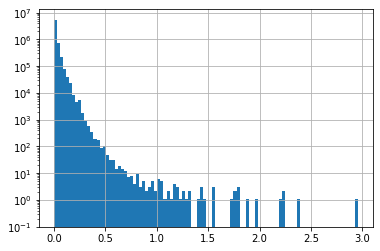

In [12]:
#Plot for weight of investor-investor pair and its counts
fig, ax = plt.subplots()
InvstrInvstrPair_accm["weight"].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [13]:
#1st step: reduce degree by threshold
InvstrInvstrPair_reduced = InvstrInvstrPair_accm[InvstrInvstrPair_accm['weight'] > 0.1]

(126244, 3)

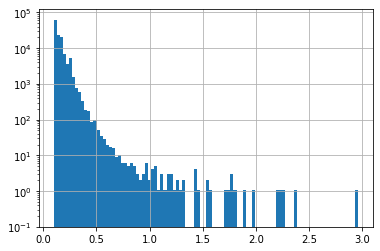

In [14]:
#Again, plot for weight of investor-investor pair and its counts
fig, ax = plt.subplots()
InvstrInvstrPair_reduced["weight"].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
InvstrInvstrPair_reduced.shape

In [15]:
#Save edge list into csv.
InvstrInvstrPair_reduced.to_csv("./data/InvInvPairs_UND.csv", header=False, index=False, sep="\t")

In [16]:
#Save investorID/name list into csv.
df_investors[["investorID", "investorname"]].to_csv("./data/Investor_UND.csv", header=False, index=False, sep="\t")